# Choice of resolution experiments

In [1]:
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

from modules import stats


In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42075,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:46377,Total threads: 1
Dashboard: http://127.0.0.1:33981/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:35675,


In [4]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/03_rbc/'
data_path = base_path + 'final_data/resolution_tests/'
config_file = base_path + 'config/resolution_tests_low.yml'

with open(config_file, 'r') as f:
    config = yaml.load(f, yaml.Loader)

RAYLEIGH = config['base']['parameters']['rayleigh']
PRANDTL = config['base']['parameters']['prandtl']
RUNS = [
    (256, 64),
    (512, 64),
    (768, 96),
    (1024, 128),
    (1280, 160),
    (1536, 192),
    (1792, 224),
    (2048, 256),
]
HIGHEST = (2048, 256)
FINE_INIT_TIME = 650.
SPIN_UP_TIME = 750.
AVG_TIME = 150.


In [8]:
data = {}
for res in RUNS:
    t_chunks = 1024*128/np.product(res)*100
    t_chunks = round(t_chunks/10)*10
    data[res] = xr.open_mfdataset(
        data_path + f'{res[0]}x{res[1]}/*.nc',
        chunks = {'x': -1, 'z': -1, 't': t_chunks}
    )
    if res[0] > 1024: data[res]['t'] = data[res]['t'] + FINE_INIT_TIME
    data[res] = data[res].isel(t=(data[res].t >= SPIN_UP_TIME))


In [10]:
nusselt = {}
rms_speed = {}
eps_k = {}
eps_T = {}
for res in RUNS:
    nusselt[res] = stats.nusselt_number(
        data[res], RAYLEIGH, PRANDTL).compute()
    rms_speed[res] = stats.rms_speed(data[res]).compute()
    eps_k[res] = stats.kinetic_dissipation(
        data[res], RAYLEIGH, PRANDTL).compute()
    eps_T[res] = stats.thermal_dissipation(
        data[res], RAYLEIGH, PRANDTL).compute()


In [11]:
metrics = {
    r'$\mathrm{Nu}$': nusselt,
    r'$u_\mathrm{rms}$': rms_speed,
    r'$\epsilon_k$': eps_k,
    r'$\epsilon_T$': eps_T,
}


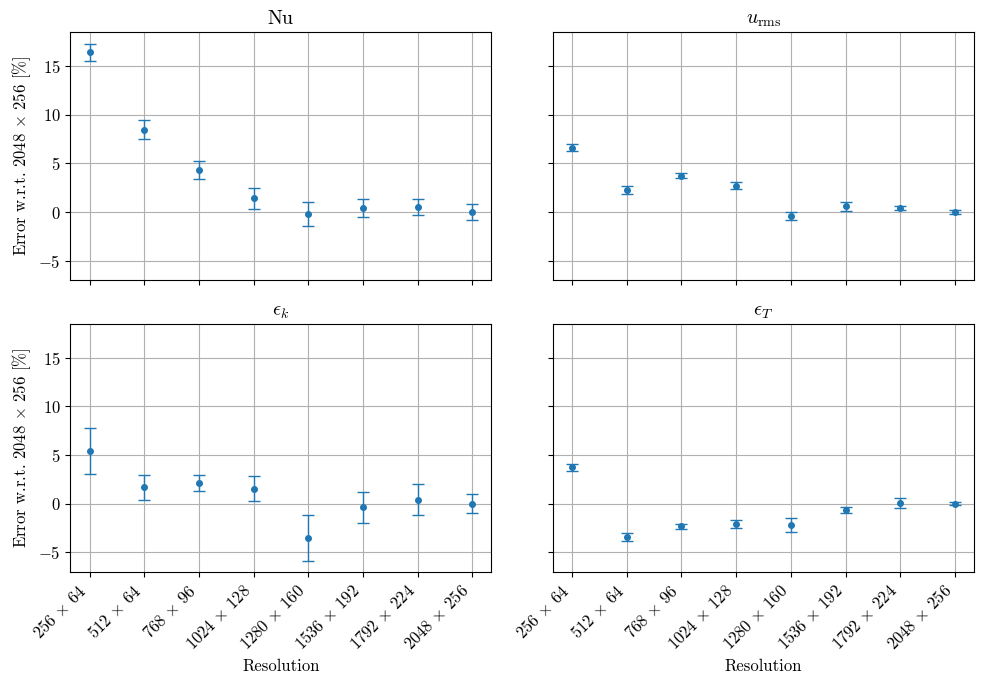

In [22]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 7))

for ax, (name, var) in zip(axes.ravel(), metrics.items()):
    mean_highest, delta_highest = stats.mean_and_uncertainty(
        var[HIGHEST], 't', AVG_TIME,
    )
    means = []
    deltas = []
    for res in RUNS:
        mean, delta = stats.mean_and_uncertainty(var[res], 't', AVG_TIME)
        means.append((mean/mean_highest - 1)*100)
        deltas.append(delta/mean_highest*100)

    ax.errorbar(
        [f'{res[0]} $\\times$ {res[1]}' for res in RUNS], means, yerr=deltas,
        capsize=4, elinewidth=1, marker='.', linestyle='',
        capthick=1, markersize=8,
    )
    ax.set_title(name)
    ax.grid()

for ax in axes[-1,:]:
    ax.set_xlabel('Resolution')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

for ax in axes[:,0]: ax.set_ylabel(
    f'Error w.r.t. {HIGHEST[0]} $\\times$ {HIGHEST[1]} [%]')

fig.tight_layout()
fig.savefig(fig_path + 'resolution_dependence.pdf')


In [23]:
client.close()
